### STEP 3 --- Example Tutorial Plotting ternary phase diagram using FH simulation data for desired Flory Matrix as discussed in STEP 1 notebook

## Example is strong repulsive interaction between DPPC-DIPC = 3.245, DPPC-CHOL = -0.29 (attractive), DIPC-CHOL = 0.852 (repulsive)

System with enhanced phase separating tendencies

/projectnb/mcprot/nayaksp/.conda/envs/openmm_plumed/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/scratch/2016482.1.w28/ipykernel_961614/1694613165.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


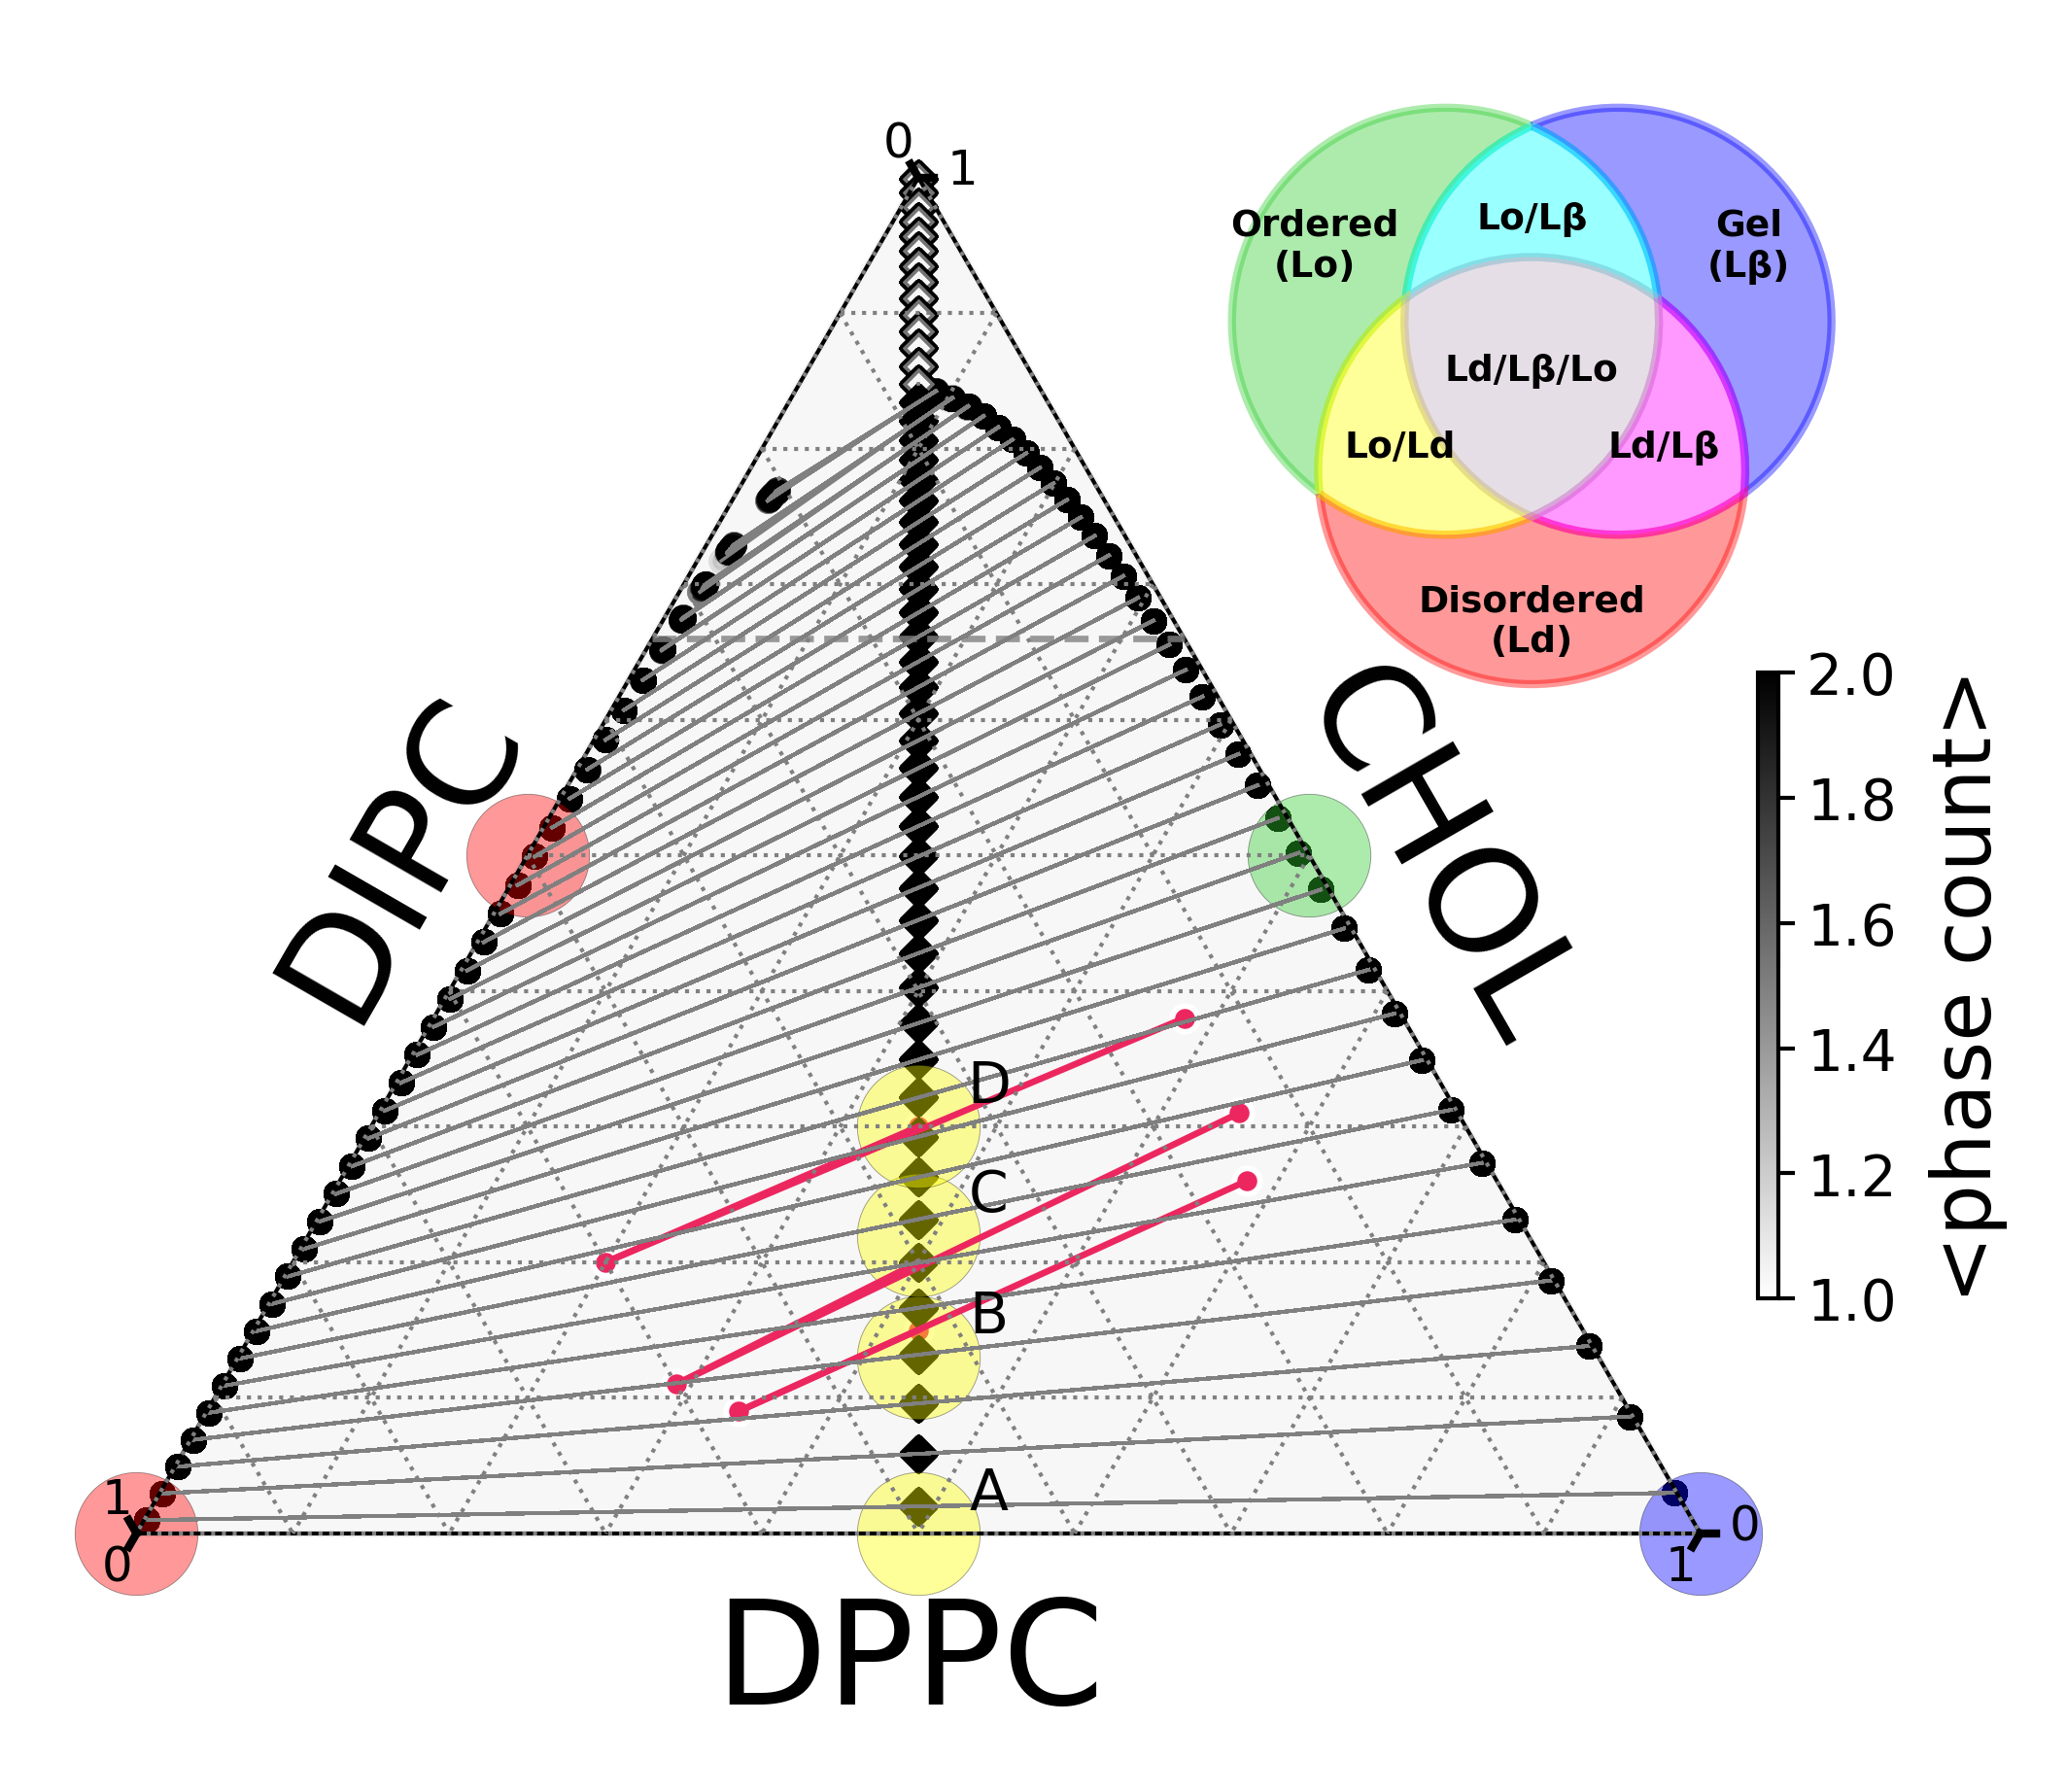

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib_venn import venn3
import ternary
import os

# --- Parameters ---
num_comp = 2
sample = 50
rep = 3
# scale = 1
z = 6
epsilon = 0.001

scale = 1
DPPC_DIPC = 1.34/scale
DPPC_CHOL = -0.06/scale
DIPC_CHOL = 0.8/scale

# # Chi values
# chi_DPPC_DIPC = 0.22
# chi_DPPC_CHOL = -0.01
# chi_DIPC_CHOL = 0.08

# DPPC_DIPC = chi_DPPC_DIPC * z / scale
# DPPC_CHOL = chi_DPPC_CHOL * z / scale
# DIPC_CHOL = chi_DIPC_CHOL * z / scale

file_path = f"data/ternary_lipid_phase_diagram_tieline_unequal_N_2_rep_3_3.245_-0.290_0.852_1.h5"
df = pd.read_hdf(file_path, key='df')
phase_count = np.arange(num_comp + 2)

# title = f"{common_title}"
# tax.set_title(title, fontsize=title_sz)

# --- Conversion Function ---
def convert_to_number_fraction(dppc_vol, dipc_vol, chol_vol):
    v_dppc = 2
    v_dipc = 2
    v_chol = 1
    dppc_num = dppc_vol / v_dppc
    dipc_num = dipc_vol / v_dipc
    chol_num = chol_vol / v_chol
    total = dppc_num + dipc_num + chol_num
    return dppc_num / total, dipc_num / total, chol_num / total

# --- Phase Calculations ---
def calculate_phases_mean(x):
    if x.sum() != 0:
        return phase_count @ x / x.sum()
    return np.nan

def calculate_phases_var(x):
    if x.sum() != 0:
        return phase_count @ (x ** 2) / x.sum() - (phase_count @ x / x.sum()) ** 2
    return np.nan

df["phase_mean"] = df["phases"].apply(calculate_phases_mean)
df["phase_var"] = df["phases"].apply(calculate_phases_var)
df.dropna(subset=["phase_mean"], inplace=True)

# --- Convert DF volume fractions to number fractions ---
df[['DPPC', 'DOPC', 'CHOL']] = df.apply(
    lambda row: pd.Series(convert_to_number_fraction(row['DPPC'], row['DIPC'], row['CHOL'])),
    axis=1
)

# --- Extract Tie-Line Data and Convert ---
dppc_list, dipc_list, chol_list, phase_mean = [], [], [], []
count_bistable = 0
count_homogenous = 0

for _, row in df.iterrows():
    bimodals = row["phi_dist_in_clusters"]
    if len(bimodals) == 2:
        for phase in bimodals:
            dppc, dipc = phase
            chol = 1 - dppc - dipc
            dppc, dipc, chol = convert_to_number_fraction(dppc, dipc, chol)
            dppc_list.append(dppc)
            dipc_list.append(dipc)
            chol_list.append(chol)
            phase_mean.append(2)
        count_bistable += 1
    else:
        dppc, dipc = bimodals[0]
        chol = 1 - dppc - dipc
        dppc, dipc, chol = convert_to_number_fraction(dppc, dipc, chol)
        dppc_list.append(dppc)
        dipc_list.append(dipc)
        chol_list.append(chol)
        phase_mean.append(1)
        count_homogenous += 1

frac_bi = count_bistable / (count_bistable + count_homogenous)
bf = pd.DataFrame({"dppc": dppc_list, "dipc": dipc_list, "chol": chol_list, "phase_mean": phase_mean})

# --- Plotting ---
common_title = fr"$\chi_{{\text{{DPPC-DIPC}}}} = \frac{{{DPPC_DIPC:.3f}}}{{{scale}}}, \quad \chi_{{\text{{DPPC-CHOL}}}} = \frac{{{DPPC_CHOL:.3f}}}{{{scale}}}, \quad \chi_{{\text{{DIPC-CHOL}}}} = \frac{{{DIPC_CHOL:.3f}}}{{{scale}}}$"
fig, ax = plt.subplots(figsize=(3.25, 3), dpi=600)
tax = ternary.TernaryAxesSubplot(ax=ax, scale=1.0)
fontsize = 18
norm = plt.Normalize(bf['phase_mean'].min(), bf['phase_mean'].max())
cmap = plt.cm.gray_r

tax.left_axis_label("DIPC", fontsize=fontsize)
tax.right_axis_label("CHOL", fontsize=fontsize)
tax.bottom_axis_label("DPPC", fontsize=fontsize)

region_colors = {
    "Lo": "limegreen", "Ld": "red", "Lβ": "blue",
    "Lo/Ld22": "yellow", "Lo/Ld30": "yellow", "Lo/Ld13": "yellow",
    "Lo/Lβ": "red", "Ld/Lβ": "yellow",
}
region_labels = {
    "Lo/Ld22": "C", "Lo/Ld30": "D", "Lo/Ld13": "B", "Ld/Lβ": "A"
}
regions = {
    "Lo": [(0.5, 0.5, 0.)],
    "Ld": [(0., 0., 1.0)],
    "Lβ": [(1., 0., 0.)],
    "Lo/Ld22": [(0.39, 0.22, 0.39)],
    "Lo/Ld30": [(0.35, 0.30, 0.35)],
    "Lo/Ld13": [(0.435, 0.13, 0.435)],
    "Lo/Lβ": [(0., 0.5, 0.5)],
    "Ld/Lβ": [(0.5, 0.0, 0.5)],
}



#####################
# --- Additional points: 20% case ---
additional_points_20 = [
    (0.40, 0.20, 0.40), 
    (0.29, 0.11, 0.60), 
    (0.55, 0.31, 0.15)
]

# additional_points_20 = [
#     (0.40, 0.20, 0.40), 
#     (0.29, 0.11, 0.60), 
#     (0.55, 0.31, 0.15)
# ]

# Plot red dots and connect with lines
for point in additional_points_20:
    tax.scatter([point], color="#ec275f", marker='o', s=10, edgecolors='white', linewidths=0.7)

# Connect the points
for i in range(len(additional_points_20) - 1):
    tax.line(additional_points_20[i], additional_points_20[i + 1], color="#ec275f", linewidth=0.8, linestyle='-')


# --- Additional points: 15% case ---
additional_points_15 = [
    (0.425, 0.15, 0.425), 
    (0.34, 0.09, 0.57), 
    (0.58, 0.26, 0.16)
]

# Plot red dots and connect with lines
for point in additional_points_15:
    tax.scatter([point], color="#ec275f", marker='o', s=10, edgecolors='white', linewidths=0.7)

# Connect the points
for i in range(len(additional_points_15) - 1):
    tax.line(additional_points_15[i], additional_points_15[i + 1], color="#ec275f", linewidth=0.8, linestyle='-')
#######################
######################


# --- Additional points: 30% case ---
additional_points_30 = [

    (0.35, 0.30, 0.35), 
    (0.20, 0.20, 0.60),
    (0.48, 0.38, 0.14) 

    #DIPC:CHOL:DPPC
]

# Plot red dots and connect with lines
for point in additional_points_30:
    tax.scatter([point], color="#ec275f", marker='o', s=10, edgecolors='white', linewidths=0.7)

# Connect the points
for i in range(len(additional_points_30) - 1):
    tax.line(additional_points_30[i], additional_points_30[i + 1], color="#ec275f", linewidth=0.8, linestyle='-')
#######################
######################




points = []
for _, row in bf.iterrows():
    point = (row['dppc'], row['chol'], row['dipc'])
    color = cmap(norm(row['phase_mean']))
    tax.scatter([point], color=color, marker='o', s=5, edgecolors='black', linewidths=1, alpha=0.1)
    points.append(point)

for i in range(0, len(points), 2):
    if i + 1 < len(points):
        tax.line(points[i], points[i + 1], linewidth=0.4, color='grey')

for _, row in df.iterrows():
    point = (row['DPPC'], row['CHOL'], row['DIPC'])
    color = cmap(norm(row['phase_mean']))
    tax.scatter([point], color=color, marker='D', s=8, edgecolors='black', linewidths=0.8, alpha=0.1)

for region, coords in regions.items():
    tax.scatter(coords, color=region_colors.get(region, 'white'), alpha=0.4, s=230, edgecolors='black', linewidths=0.1)
    if region in region_labels:
        for (x, y, z) in coords:
            tax.annotate(region_labels[region], (x + 0.02, y + 0.05, z), fontsize=7, ha='center', va='top', color="black")

tax.boundary(linewidth=0.5)
tax.gridlines(multiple=0.1, color="gray")
tax.ticks(axis='lbr', linewidth=1, fontsize=6)
tax.clear_matplotlib_ticks()

cax = inset_axes(ax, width="3%", height="80%", loc='center right',
                 bbox_to_anchor=(0.6, 0.2, 0.4, 0.5),
                 bbox_transform=ax.transAxes, borderpad=0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('<phase count>', fontsize=10)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(axis='y', which='major', labelsize=7, length=2, color='black', width=0.5, zorder=100, pad=1.5)

axins = inset_axes(ax, width=1.2, height=1.2, bbox_to_anchor=(1.06, 1.05),
                   bbox_transform=ax.transAxes, loc='upper right', borderpad=0)
venn = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=('', '', ''))
subset_labels = {
    '100': 'Ordered\n(Lo)', '001': 'Disordered\n(Ld)', '010': 'Gel\n(Lβ)',
    '101': 'Lo/Ld', '110': 'Lo/Lβ', '011': 'Ld/Lβ', '111': 'Ld/Lβ/Lo'
}
for k, v in subset_labels.items():
    if venn.get_label_by_id(k):
        venn.get_label_by_id(k).set_text(v)
        venn.get_label_by_id(k).set_fontsize(4.5)
        venn.get_label_by_id(k).set_fontweight("bold")

venn_colors = {
    '100': "limegreen", '001': "red", '010': "blue",
    '101': "yellow", '110': "cyan", '011': "magenta", '111': "#C2ADC2"
}
for sid, col in venn_colors.items():
    patch = venn.get_patch_by_id(sid)
    if patch:
        patch.set_color(col)
        patch.set_alpha(0.4)

# Remove default axes
for spine in ax.spines.values():
    spine.set_visible(False)

for sid, col in venn_colors.items():
    patch = venn.get_patch_by_id(sid)
    if patch:
        patch.set_color(col)
        patch.set_alpha(0.4)
        
# --- Add horizontal line at CHOL = 0.66 ---
chol_fixed = 0.66
dp_start, dp_end = 0.0, 0.34
dip_start, dip_end = 0.34, 0.0
line_start = (dp_start, chol_fixed, dip_start)
line_end = (dp_end, chol_fixed, dip_end)
tax.line(line_start, line_end, linewidth=0.8, linestyle='--', color='grey', alpha=0.8)
# tax.annotate(position=(0.17, chol_fixed + 0.02, 0.17), fontsize=6, ha='center', color='black')


plt.tight_layout()
# os.makedirs("plot_FH_ternary", exist_ok=True)
# plt.savefig("plot_FH_ternary/tieline_phase_diagramSI.png", dpi=1000, bbox_inches='tight')
# plt.show()
